1) **Setting up the Kitchen**

Target:
Get the set-up right

a) Set Transforms


   *i)Figure out mean and std value for entire dataset for normalization
     (found to be as mean=0.1308 std=0.3084)*


b) Set Data Loader

c) Set Basic Working Code

d) Set Basic Training  & Test Loop

   *i) Epochs=15*

Results:

Parameters: 6.3M

Best Training Accuracy: 99.97 (Epoch:14)

Best Test Accuracy: 99.22     (Epoch:13)

Analysis:


a)Extremely Heavy Model for such a problem(too many parameters ulimate goal is 10k)

b)Model is over-fitting(train>test and gap between train and test is large)

c)Train is very close to 100 which leaves very less gap (0.03) to improve test by regularization



# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


# Apply Transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1308,), (0.3084,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1308,), (0.3084,))
                                       ])



# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


# **Finding Mean and Std for entire dataset**

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
#train_data = train.transform(train_data.numpy())

#print('[Train]')
#print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
#print(' - Tensor Shape:', train.train_data.size())
#print(' - mean:', torch.mean(train_data))
#print(' - std:', torch.std(train_data))

#test_data = test.test_data
#test_data = test.transform(test_data.numpy())

#print('[Test]')
#print(' - Numpy Shape:', test.test_data.cpu().numpy().shape)
#print(' - Tensor Shape:', test.test_data.size())
#print(' - mean:', torch.mean(test_data))
#print(' - std:', torch.std(test_data))



In [0]:
#Combined mean

#x1=torch.mean(train_data)
#n1=60000*28*28
#x2=torch.mean(test_data)
#n2=10000*28*28
#mean=(x1*n1+x2*n2)/(n1+n2)
#print(mean)

In [0]:
#Combined Std dev
#d1=(x1-mean)**2
#d2=(x2-mean)**2
#s1=(torch.std(train_data))**2
#s2=(torch.std(test_data))**2
#var=((s1+d1)*n1+(s2+d2)*n2)/(n1+n2)
#std=var**0.5
#print(std)

# Dataloader Arguments & Test/Train Dataloaders


In [73]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4241)
 - max: tensor(2.8184)
 - mean: tensor(0.0006)
 - std: tensor(0.9991)
 - var: tensor(0.9981)
torch.Size([128, 1, 28, 28])
torch.Size([128])


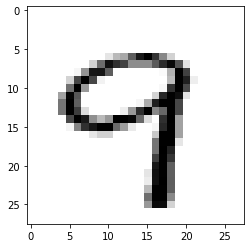

In [74]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

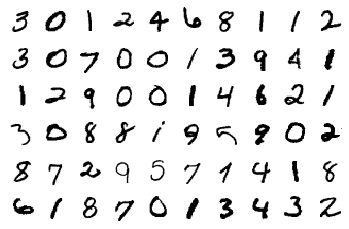

In [75]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            
            nn.ReLU()
        ) # output_size = 28

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            
            nn.ReLU()
        ) # output_size = 28
        


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14


        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),     
            
            nn.ReLU()
        ) # output_size = 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        ) # output_size = 14
        
        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7


        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 5
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 3
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=10, kernel_size=(3, 3), padding=0),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [77]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]          73,856
              ReLU-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
        MaxPool2d-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 512, 5, 5]       1,180,160
             ReLU-12            [-1, 512, 5, 5]               0
           Conv2d-13           [-1, 1024, 3, 3]       4,719,616
             ReLU-14           [-1

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [79]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.020170772448182106 Batch_id=468 Accuracy=82.67: 100%|██████████| 469/469 [00:14<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9783/10000 (97.83%)

EPOCH: 1


Loss=0.003922412637621164 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.007744113449007273 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.030339360237121582 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 38.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.04212479665875435 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.02374308370053768 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.006367037538439035 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:13<00:00, 37.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.024530714377760887 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=8.90195369720459e-05 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.0031598906498402357 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.001580913900397718 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=9.783109271666035e-05 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:13<00:00, 37.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.0006152788992039859 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.0002218782901763916 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=7.264813029905781e-05 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]



Test set: Average loss: 0.0385, Accuracy: 9913/10000 (99.13%)



Text(0.5, 1.0, 'Test Accuracy')

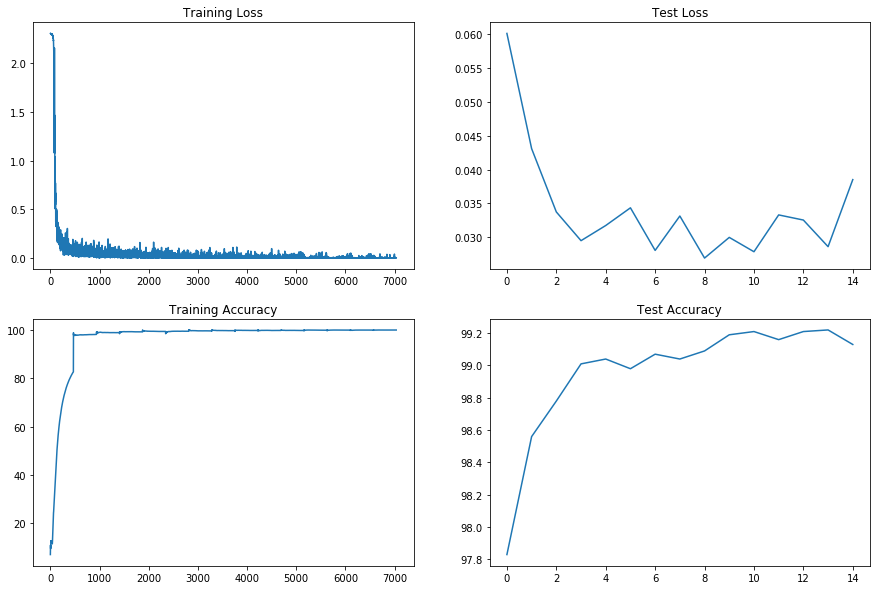

In [80]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")